In [47]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt


CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}



In [48]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

# plt.show()

29


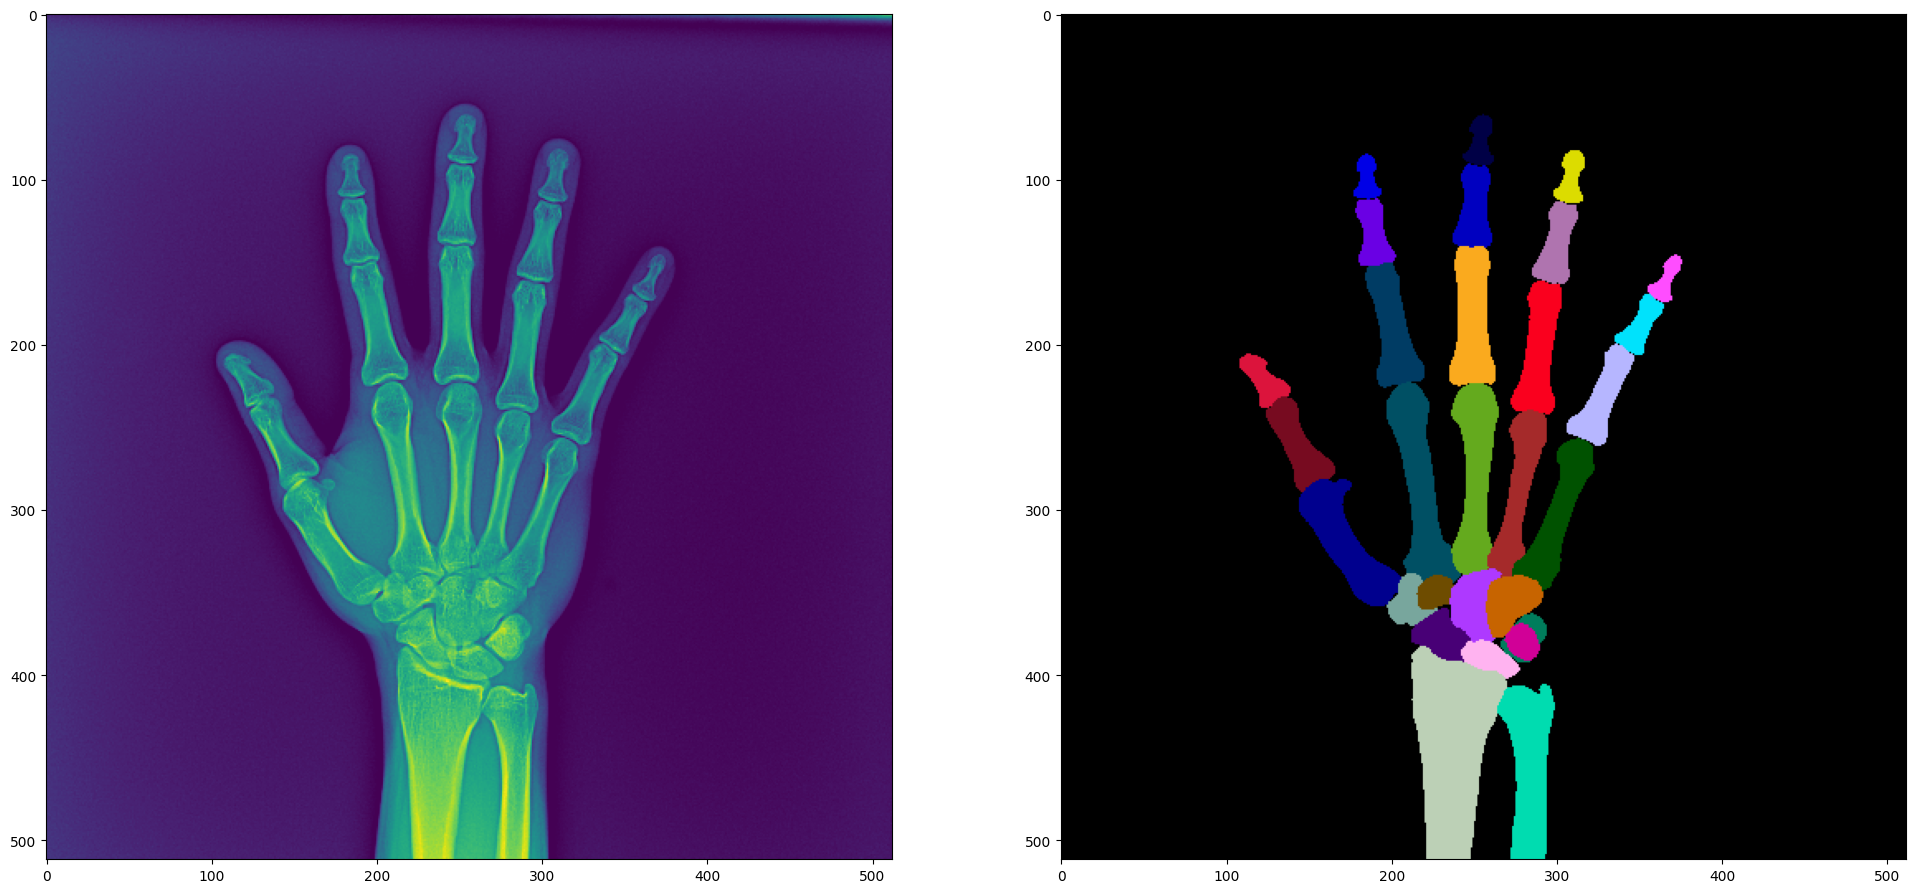

In [49]:
# 특정 image와 label을 지정해서 확인할 수 있는 함수 추가
def visualize_specific_sample(image_path, label_path, transforms=None):
    # 이미지를 불러옵니다
    image = cv2.imread(image_path)
    image = image / 255.0

    # JSON 레이블 파일을 읽습니다
    with open(label_path, "r") as f:
        annotations = json.load(f)
    annotations = annotations["annotations"]

    # (H, W, NC) 모양의 label을 생성합니다
    label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
    label = np.zeros(label_shape, dtype=np.uint8)
    print(len(CLASS2IND))


    # 클래스별로 마스크 생성
    for ann in annotations:
        c = ann["label"]
        class_ind = CLASS2IND[c]
        points = np.array(ann["points"])

        # polygon 포맷을 dense한 mask 포맷으로 바꿉니다
        class_label = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(class_label, [points], 1)
        label[..., class_ind] = class_label

    # Transformations 적용
    if transforms is not None:
        inputs = {"image": image, "mask": label}
        result = transforms(**inputs)

        image = result["image"]
        label = result["mask"]

    # 시각화를 위한 형식 변환
    image = image.transpose(2, 0, 1)  # Channel First
    label = label.transpose(2, 0, 1)

    image = torch.from_numpy(image).float()
    label = torch.from_numpy(label).float()

    return image, label

# 시각화 예제
# image_path = "../test_data/image/image166.png"
# label_path = "../test_data/json/image166.json"

# level2-cv-semanticsegmentation-cv-10-lv3\code\test_data\image\image1662342787622.png
image_path = "../test_data/image/image1662342787622.png"
label_path = "../test_data/json/image1662342787622.json"

# 변환 적용
transforms = A.Resize(512, 512)
image, label = visualize_specific_sample(image_path, label_path, transforms)

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image[0])    # color map 적용을 위해 channel 차원을 생략합니다.
ax[1].imshow(label2rgb(label.numpy()))

plt.show()
